### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [42]:
# Load necessary packages
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch
from pathlib import Path

#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [43]:
# MAKE CONFIGS
# MAKE CONFIGS
RUN_SIMS = True
DEVICE = "cpu"

# Define a model
MODEL = "ddm" #list(ssms.config.model_config.keys())[np.random.randint(0, len(ssms.config.model_config.keys()))]
OUT_FOLDER = Path("torch_nb_data") / "lan_mlp" / "training_data"
MODEL_FOLDER = Path("torch_nb_data") / "jax_models" / "lan"
N_DATA_FILES = 2
os.makedirs(OUT_FOLDER, exist_ok=True)

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 1000
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = OUT_FOLDER
# Specify number of training samples per parameter set
generator_config["n_training_samples_by_parameter_set"] = 2000

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [3]:
# MAKE DATA
my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

for i in range(2):
    print(i)
    training_data = my_dataset_generator.generate_data_training_uniform(save=True)

n_cpus used:  12
checking:  torch_nb_data/lan_mlp/ddm
0
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  torch_nb_data/lan_mlp/ddm/training_data_f6f87598521311f088336ae25f443f62.pickle
1
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  torch_nb_data/lan_mlp/ddm/training_data_0456bed4521411f088336ae25f443f62.pickle


#### Prepare for Training

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [44]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS

network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config["layer_sizes"] = [100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "linear"]

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)
train_config["cpu_batch_size"] = 4096
train_config["gpu_batch_size"] = 4096
train_config["learning_rate"] = 1e-3

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 4096, 'gpu_batch_size': 4096, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.001, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [45]:
# 
TRAINING_TYPE = 'lan' # 'lan', 'cpn', 'opn'

# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = Path("torch_nb_data/lan_mlp") / MODEL  # + "/training_data_0_nbins_0_n_1000/"
file_list_ = [str(p) for p in folder_.iterdir()]

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=train_config["cpu_batch_size"],
    features_key=f"{TRAINING_TYPE}_data",
    label_key=f"{TRAINING_TYPE}_labels",
    label_lower_bound=np.log(1e-10)
)

torch_training_dataloader = torch.utils.data.DataLoader(
    torch_training_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=train_config["cpu_batch_size"],
    features_key=f"{TRAINING_TYPE}_data",
    label_key=f"{TRAINING_TYPE}_labels",
    label_lower_bound=np.log(1e-10)
)

torch_validation_dataloader = torch.utils.data.DataLoader(
    torch_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

We can now load a network, and save the configuration files for convenience.

In [46]:
# LOAD NETWORK
net = lanfactory.trainers.TorchMLP(
    network_config=deepcopy(network_config),
    network_type="lan",
    input_shape=torch_training_dataset.input_dim,
    save_folder=str(Path("/torch_nb_data/torch_models/")),
    generative_model_id=MODEL,
)

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id=MODEL + "_torch_",
    save_folder=str(Path("torch_nb_data/torch_models/" + MODEL + "_lan" + "/")),
    network_config=network_config,
    train_config=train_config,
    allow_abs_path_folder_generation=True,
)

tanh
tanh
tanh
linear
Found folder:  torch_nb_data
Moving on...
Found folder:  torch_nb_data/torch_models
Moving on...
Found folder:  torch_nb_data/torch_models/ddm_lan
Moving on...
Saved network config
Saved train config


### Architecture

Quick look at the simple MLP architecture of the network.

In [47]:
print(net)

TorchMLP(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)


To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [48]:
# TRAIN MODEL
model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
    model=net,
    train_config=train_config,
    train_dl=torch_training_dataloader,
    valid_dl=torch_validation_dataloader,
    allow_abs_path_folder_generation=False,
    pin_memory=True,
    seed=None,
)

# model_trainer.train_model(save_history=True, save_model=True, verbose=0)
model_trainer.train_and_evaluate(
    wandb_on=False,
    output_folder=Path("torch_nb_data/torch_models/" + MODEL + "_lan" + "/"),
    output_file_id=MODEL,
)
# LOAD MODEL

train_config is passed as dictionary: 

{'cpu_batch_size': 4096, 'gpu_batch_size': 4096, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.001, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_lanfactory/LANfactory/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


wandb not available
wandb not available
epoch: 0/5, batch: 0/976, batch_loss: 4.6360
epoch: 0/5, batch: 100/976, batch_loss: 2.8933
epoch: 0/5, batch: 200/976, batch_loss: 0.8874
epoch: 0/5, batch: 300/976, batch_loss: 0.6737
epoch: 0/5, batch: 400/976, batch_loss: 0.5093
epoch: 0/5, batch: 500/976, batch_loss: 0.3759
epoch: 0/5, batch: 600/976, batch_loss: 0.2766
epoch: 0/5, batch: 700/976, batch_loss: 0.2904
epoch: 0/5, batch: 800/976, batch_loss: 0.2527
epoch: 0/5, batch: 900/976, batch_loss: 0.2654
Epoch took 0 / 5, took 11.991927146911621 seconds
wandb not available
wandb not available
epoch 0 / 5, validation_loss: 0.2389
wandb not available
wandb not available
epoch: 1/5, batch: 0/976, batch_loss: 0.2436
epoch: 1/5, batch: 100/976, batch_loss: 0.2326
epoch: 1/5, batch: 200/976, batch_loss: 0.2030
epoch: 1/5, batch: 300/976, batch_loss: 0.2105
epoch: 1/5, batch: 400/976, batch_loss: 0.2169
epoch: 1/5, batch: 500/976, batch_loss: 0.1898
epoch: 1/5, batch: 600/976, batch_loss: 0.182

#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [49]:
model_path = Path("torch_nb_data/torch_models") / (MODEL + "_lan")
network_file_path = next(model_path.glob("*state_dict*"))

network = lanfactory.trainers.LoadTorchMLPInfer(
    model_file_path=network_file_path,
    network_config=network_config,
    input_dim=torch_training_dataset.input_dim,
)

Setting network type to "lan" or "cpn" based on train_output_type. 
Note: This is only a default setting, and can be overwritten by the network_type argument.
tanh
tanh
tanh
linear


In [51]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(
    torch.from_numpy(np.array(ssms.config.model_config[MODEL]['default_params'] + [0.65, 1.0], dtype=np.float32))
)
print("direct call out: ", direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(
    np.array(ssms.config.model_config[MODEL]['default_params'] + [0.65, 1.0], dtype=np.float32)
)
print("predict_on_batch out: ", predict_on_batch_out)

direct call out:  tensor([-1.0772])
predict_on_batch out:  [-1.0771531]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Data
data = pd.DataFrame(
    np.zeros((2000, len(ssms.config.model_config[MODEL]['params']) + 2), dtype=np.float32),
    columns=ssms.config.model_config[MODEL]['params'] + ["rt", "choice"],
)

# Set parameters
for i, param in enumerate(ssms.config.model_config[MODEL]['params']):
    data.loc[:, param] = np.float32(ssms.config.model_config[MODEL]['default_params'][i])

# Set rt and choice
data.loc[:999, "rt"] = np.linspace(5, 0, 1000).astype(np.float32)
data.loc[1000:, "rt"] = np.linspace(0, 5, 1000).astype(np.float32)
data.loc[:999, "choice"] = -1.
data.loc[1000:, "choice"] = 1.

# Network predictions
predict_on_batch_out = network.predict_on_batch(data.values.astype(np.float32))

# Simulations
from ssms.basic_simulators.simulator import simulator

sim_out = {}
for i in range(10):
    sim_out[i] = simulator(model=MODEL, theta=data.values[0, :-2], n_samples=2000)

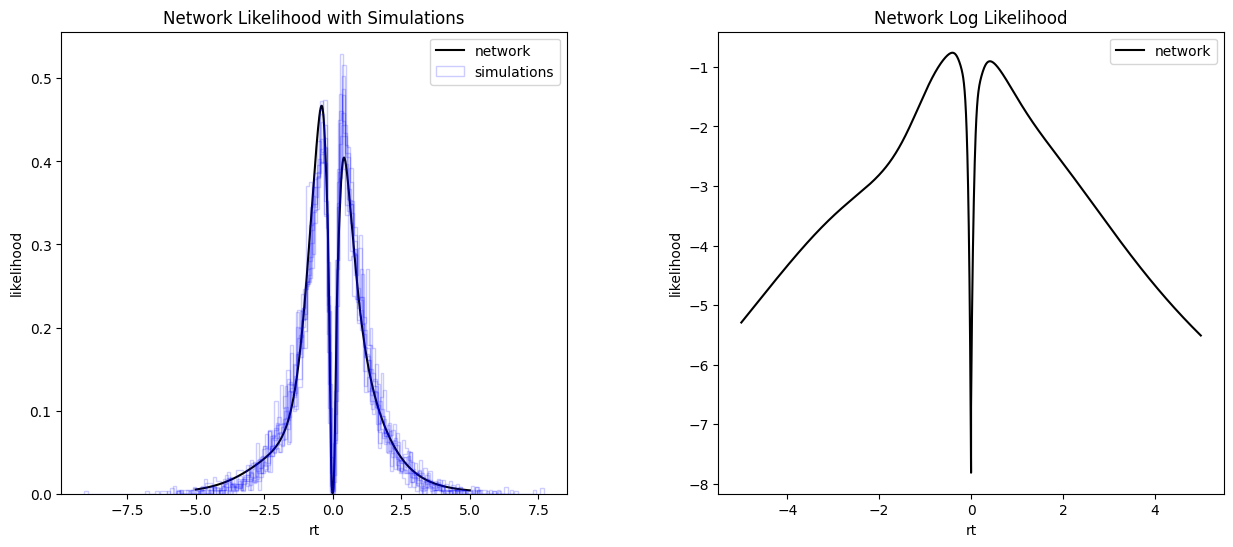

In [ ]:
import matplotlib.pyplot as plt

# Create figure with specific spacing
fig = plt.figure(figsize=(15, 6))

# First subplot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(
    data["rt"] * data["choice"],
    np.exp(predict_on_batch_out),
    color="black",
    label="network",
)

# Plot simulations
for i in range(10):
    my_seed = np.random.choice(1000000)
    sim_out = simulator(
        model=MODEL, 
        theta=data.values[0, :-2], 
        n_samples=2000, 
        random_state=my_seed
    )
    ax1.hist(
        sim_out["rts"] * sim_out["choices"],
        bins=100,
        histtype="step",
        label="simulations" if i == 0 else None,
        color="blue",
        alpha=0.2,
        density=True,
    )

ax1.legend()
ax1.set_title("Network Likelihood with Simulations")
ax1.set_xlabel("rt")
ax1.set_ylabel("likelihood")

# Second subplot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(
    data["rt"] * data["choice"],
    predict_on_batch_out,
    color="black",
    label="network",
)

ax2.legend()
ax2.set_title("Network Log Likelihood")
ax2.set_xlabel("rt")
ax2.set_ylabel("likelihood")

# Adjust spacing
plt.subplots_adjust(wspace=0.3)
plt.show()

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END